In [11]:
from functools import partial, reduce
product = partial(reduce, lambda x,y: x * y)

from jax import numpy as jnp
import arviz as az
from scipy import stats

from ipywidgets import interact, widgets
from ipywidgets.widgets import IntSlider

from report import Report
from eda import intslider_wrap

reportD = Report("data/d-10262021.csv", abso=False, unknown_feature="D")
reportB0 = Report("data/b0-10262021.csv", abso=False, unknown_feature="B0")
reportB1 = Report("data/b1-10262021.csv", abso=False, unknown_feature="B1")
reportB2 = Report("data/b2-10262021.csv", abso=False, unknown_feature="B2")


# D

In [2]:
dfD = reportD.df

ntrct0 = interact(colidx=intslider_wrap(IntSlider, dfD))
ntrct1 = interact(colidx_x=intslider_wrap(IntSlider, dfD), colidx_y=intslider_wrap(IntSlider, dfD), colidx_color=intslider_wrap(IntSlider, dfD))

In [3]:
@ntrct0
def mkscatter(colidx: int): 
    reportD._mkscatter(dfD.columns[colidx])

interactive(children=(IntSlider(value=0, description='colidx', max=8), Output()), _dom_classes=('widget-intera…

In [4]:
@ntrct0
def mkkde(colidx: int): 
    """Kernel density estimation"""
    reportD._mkkde(dfD.columns[colidx])

interactive(children=(IntSlider(value=0, description='colidx', max=8), Output()), _dom_classes=('widget-intera…

In [5]:
# I recommend looking at colidx_x=5, coldx_y=1, colidx_color=6 
@ntrct1
def heatmap(colidx_x: int, colidx_y: int, colidx_color: int): 
    return reportD._heatmap(dfD.columns[colidx_x], dfD.columns[colidx_y], dfD.columns[colidx_color])

interactive(children=(IntSlider(value=0, description='colidx_x', max=8), IntSlider(value=0, description='colid…

In [6]:
print(reportD.report_negative_solutions())

Solver gave a negative root 0.01% of the time


In [18]:
# let's investigate that 0.01%
negative_record = dfD[dfD.Root < 0]
negative_record

,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
4648,7.154015,1.729258e+11,1.511280e+10,1.817954e+10,2.837746e+10,-3.618534e+11,-8.737479e-09,5.347792e+11,2.859888e+23


In [ ]:
class Aux(Report): 
    def __init__(self, filepath: str, *, unknown_feature: str, abso: bool, invariant: callable, dimensionless_invariant: callable): 
        super().__init__(filepath, unknown_feature=unknown_feature, abso=abso)
        self.invariant = invariant
        self.dimensionless_invariant = dimensionless_invariant
        self.df = self.df.assign(
            invariant_polynomial=self.invariant(self.df.A, self.df.Root, self.df.B0, self.df.B1, self.df.B2),
            dimensionless_invariant_polynomial=self.dimensionless_invariant(self.df.A, self.df.Root, self.df.B0, self.df.B1, self.df.B2)
        )
        # self.invariant_polynomial_lowest_epsilon = min(10 ** (- k) for k in range(-16, 32) if (self.df.invariant_polynomial.abs() < 10 ** (- k)).sum() / self.df.shape[0] >= 0.5)
        # self.invariant_polynomial_dimensionless_lowest_epsilon = min(10 ** (- k) for k in range(-16, 32) if (self.df.dimensionless_invariant_polynomial.abs() < 10 ** (- k)).sum() / self.df.shape[0] >= 0.5)
        

In [41]:
# according to my research, the zeros are equal to the zeros of this function
def invariant_D(A: float, D: float, *balances: list) -> float: 
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        D ** (n + 1) 
        + 
        (A - 1 / n ** n) * n_raised_2n * product(balances) * D 
        + 
        (- A * n_raised_2n * product(balances) * sum(balances))
    )
invariant_D(negative_record.A, negative_record.Root, negative_record.B0, negative_record.B1, negative_record.B2).values[0]

-3.1691265005705735e+30

In [ ]:
# Theory does not line up with reality. 

In [37]:
# For posteriry: the dimensionless version
def invariant_D_dimensionless(A: float, D: float, *balances: list) -> float: 
    """Invariant polynomial divided by product of balances and then divided by D. 
    
    My invariant polynomial is of units $ ^ (n + 1), if you squint, 
    and the dimensionless version is of unit $ ^ 0
    """
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        product(D / b for b in balances)
        +
        (A - 1 / n ** n) * n_raised_2n
        + 
        (- A * n_raised_2n * sum(balances) / D)
    )
invariant_D_dimensionless(negative_record.A, negative_record.Root, negative_record.B0, negative_record.B1, negative_record.B2).values[0]

3.410605131648481e-13

In [ ]:
auxD = Aux("data/d-10262021.csv", abso=False, unknown_feature="D", invariant=invariant_D, dimensionless_invariant=invariant_D_dimensionless)

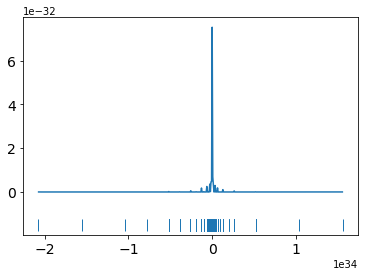

In [89]:
# which to be fair is mostly that low. 
az.plot_kde(auxD.df.invariant_polynomial.values, rug=True);

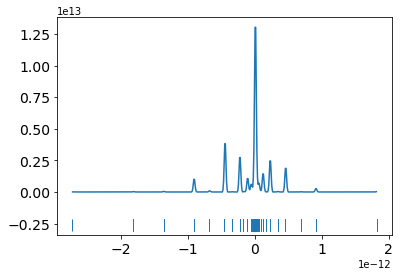

In [91]:
az.plot_kde(auxD.df.dimensionless_invariant_polynomial.values, rug=True);

In [92]:
# at epsilon 1e-32, dimensionless invariant is solid 41 % of the time
(auxD.df.dimensionless_invariant_polynomial.abs() < 1e-32).sum() / dfD.shape[0]

0.4156

In [93]:
# At the same epsilon, the invariant of dimension $ ^ (n + 1) is solid 39% of the time
(auxD.df.invariant_polynomial.abs() < 1e-32).sum() / dfD.shape[0]

0.3891

In [95]:
# Out of time before meeting with morgan to write the code that tries to optimize this epsilon

# B0

In [143]:
dfB0 = reportB0.df

ntrct0_B0 = interact(colidx=intslider_wrap(IntSlider, dfB0))
ntrct1_B0 = interact(colidx_x=intslider_wrap(IntSlider, dfB0), colidx_y=intslider_wrap(IntSlider, dfB0), colidx_color=intslider_wrap(IntSlider, dfB0))

In [144]:
@ntrct0_B0
def mkscatter_B0(colidx: int): 
    reportB0._mkscatter(dfB0.columns[colidx])

interactive(children=(IntSlider(value=0, description='colidx', max=8), Output()), _dom_classes=('widget-intera…

In [145]:
@ntrct0_B0
def mkkde_B0(colidx: int): 
    """Kernel density estimation"""
    reportB0._mkkde(dfB0.columns[colidx])

interactive(children=(IntSlider(value=0, description='colidx', max=8), Output()), _dom_classes=('widget-intera…

In [155]:
# I recommend looking at colidx_x=5, coldx_y=2, colidx_color=6 
@ntrct1_B0
def heatmap(colidx_x: int, colidx_y: int, colidx_color: int): 
    return reportB0._heatmap(dfB0.columns[colidx_x], dfB0.columns[colidx_y], dfB0.columns[colidx_color])

interactive(children=(IntSlider(value=5, description='colidx_x', max=8), IntSlider(value=2, description='colid…

In [103]:
print(reportB0.report_negative_solutions())
# let's investigate that 0.01%
negative_record = dfB0[dfB0.Root < 0]
negative_record

Solver gave a negative root 15.24% of the time


,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
6,2.761841,2.981154e+11,5.227535e+10,9.554543e+10,6.647119e+10,-4.521133e+09,-1.548203e-07,5.679648e+10,3.225841e+21
9,1.748798,2.385252e+11,2.610357e+10,1.477807e+10,1.638546e+11,-1.501116e+10,-9.185547e-10,4.111473e+10,1.690421e+21
19,6.871461,3.806703e+11,2.159605e+10,8.638521e+10,1.306443e+11,-2.266875e+09,-7.545308e-07,2.386292e+10,5.694390e+20
21,1.306911,2.201613e+11,4.917254e+10,8.332048e+10,2.095746e+09,-7.084168e+10,-2.334858e-09,1.200142e+11,1.440341e+22
27,5.003352,3.575170e+11,9.232462e+10,6.675205e+10,5.991368e+10,-4.806517e+09,-3.058321e-07,9.713114e+10,9.434458e+21
...,...,...,...,...,...,...,...,...,...
9958,5.229613,4.068118e+11,5.638640e+10,6.784622e+10,1.004073e+11,-4.392870e+09,-4.592855e-07,6.077927e+10,3.694120e+21
9970,0.880421,4.862711e+11,4.657358e+08,8.382879e+10,1.371555e+11,-2.779246e+10,-6.323585e-08,2.825820e+10,7.985257e+20
9982,1.498392,5.465826e+11,1.354699e+11,9.755697e+10,6.081558e+10,-3.372020e+10,-3.836964e-08,1.691901e+11,2.862530e+22
9989,2.046654,4.047818e+11,5.565246e+10,1.515010e+11,7.927647e+10,-8.549614e+09,-2.382907e-07,6.420208e+10,4.121907e+21


<AxesSubplot:>

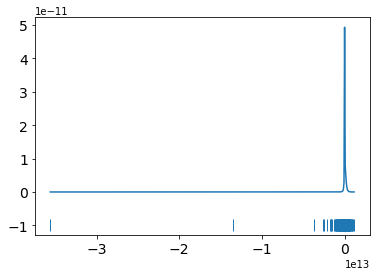

In [153]:
az.plot_kde(dfB0[stats.zscore(dfB0.Root) < 3].Root, rug=True)

In [109]:
class AuxB0(Report): 
    def __init__(self, filepath: str, *, unknown_feature: str, abso: bool, invariant: callable, dimensionless_invariant: callable): 
        super().__init__(filepath, unknown_feature=unknown_feature, abso=abso)
        self.invariant = invariant
        self.dimensionless_invariant = dimensionless_invariant
        self.df = self.df.assign(
            invariant_polynomial=self.invariant(self.df.A, self.df.D, self.df.Root, self.df.B1, self.df.B2),
            dimensionless_invariant_polynomial=self.dimensionless_invariant(self.df.A, self.df.D, self.df.Root, self.df.B1, self.df.B2)
        )

def invariant_B0(A: float, D: float, b0: float, b1: float, b2: float) -> float: 
    return b0 ** 2 + (b1 + b2 + (1 / A / 3 ** 3 - 1) * D) * b0 + (- D ** (3 + 1) / A / 3 ** (2 * 3) / b1 / b2)

def invariant_B0_dimensionless(A: float, D: float, b0: float, b1: float, b2: float) -> float: 
    """Hit it with fun x->x/D^2 """
    return (b0 / D) ** 2 + (b1 + b2 + (1 / A / 3 ** 3 - 1) / D) * b0 + (- D ** (1 + 1) / A / 3 ** (2 * 3) / b1 / b2)
auxb0 = AuxB0("data/b0-10262021.csv", abso=False, unknown_feature="B0", invariant=invariant_B0, dimensionless_invariant=invariant_B0_dimensionless)

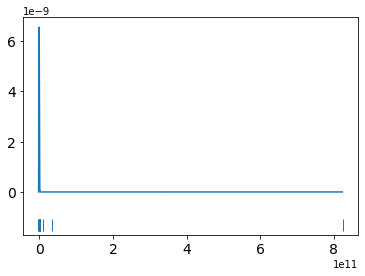

In [111]:
# which to be fair is mostly that low. 
az.plot_kde(auxb0.df.invariant_polynomial.values, rug=True);

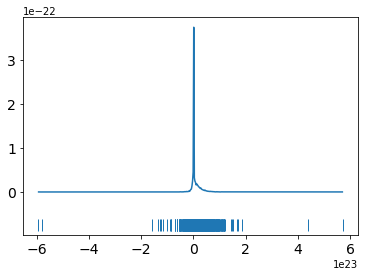

In [112]:
az.plot_kde(auxb0.df.dimensionless_invariant_polynomial.values, rug=True);

In [123]:
# at epsilon 1e-32, dimensionless invariant is solid 0 % of the time
(auxb0.df.dimensionless_invariant_polynomial.abs() < auxb0.df.Y.abs()).sum() / auxb0.df.shape[0]

0.0

In [122]:
# At the same epsilon, the invariant of dimension $ ^ (n + 1) is solid 14% of the time
(auxb0.df.invariant_polynomial.abs() < auxb0.df.Y.abs()).sum() / auxb0.df.shape[0]

0.1496

# B1 and B2 should be exactly the same

In [120]:
dfB1 = reportB1.df

print(reportB1.report_negative_solutions())
# let's investigate that 0.01%
negative_record = dfB1[dfB1.Root < 0]
negative_record

Solver gave a negative root 14.6% of the time


,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
0,0.947686,4.665698e+11,1.010696e+10,2.376084e+10,6.083186e+10,-1.949301e+11,-3.085503e-09,2.186910e+11,4.782574e+22
2,3.049860,3.375096e+11,6.524776e+10,4.895298e+10,1.112820e+11,-4.966386e+09,-2.163730e-07,5.391936e+10,2.907298e+21
5,3.230134,4.225037e+11,1.425519e+11,7.142018e+10,6.556592e+10,-6.695648e+09,-3.314742e-07,7.811583e+10,6.102083e+21
17,2.374701,2.731083e+11,1.751239e+11,1.270613e+10,4.409574e+10,-7.309002e+09,-5.019537e-08,2.001513e+10,4.006056e+20
18,2.769905,3.008512e+11,1.481929e+11,2.389257e+10,7.481818e+10,-4.662530e+09,-2.217639e-07,2.855510e+10,8.153936e+20
...,...,...,...,...,...,...,...,...,...
9968,0.834007,2.935668e+11,3.066982e+10,1.163752e+11,6.928710e+09,-1.473103e+11,-6.417081e-10,2.636855e+11,6.953002e+22
9973,0.189989,5.849970e+11,1.118977e+11,6.961937e+09,2.323137e+11,-1.277935e+11,-7.799440e-08,1.347554e+11,1.815901e+22
9974,2.847247,3.074011e+11,1.092751e+11,2.860345e+10,1.135055e+11,-4.094166e+09,-1.959203e-07,3.269762e+10,1.069134e+21
9979,2.617537,1.758211e+11,9.007331e+09,1.801129e+10,6.893732e+10,-7.814815e+09,-1.996209e-10,2.582610e+10,6.669876e+20


In [125]:
dfD.B0 ** 10

0       3.986112e+107
1       2.053407e+108
2       1.631332e+106
3       6.693374e+112
4       1.063035e+113
            ...      
9995    5.470156e+112
9996    2.843839e+114
9997    7.449897e+110
9998    3.626554e+109
9999    2.018063e+112
Name: B0, Length: 10000, dtype: float64

In [126]:
dfD.D ** (10 + 1)

0       2.217737e+122
1       4.962554e+120
2       1.340782e+125
3       2.188777e+121
4       2.223463e+125
            ...      
9995    1.407789e+123
9996    1.192433e+117
9997    5.697693e+125
9998    4.279507e+123
9999    1.286855e+127
Name: D, Length: 10000, dtype: float64

In [ ]:
# according to my research, the zeros are equal to the zeros of this function
def invariant_D(A: float, D: float, *balances: list) -> float: 
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        D ** (n + 1) 
        + 
        (A - 1 / n ** n) * n_raised_2n * product(balances) * D 
        + 
        (- A * n_raised_2n * product(balances) * sum(balances))
    )
invariant_D(negative_record.A, negative_record.Root, negative_record.B0, negative_record.B1, negative_record.B2).values[0]

In [ ]:
# For posteriry: the dimensionless version
def invariant_D_dimensionless(A: float, D: float, *balances: list) -> float: 
    """Invariant polynomial divided by product of balances and then divided by D. 
    
    My invariant polynomial is of units $ ^ (n + 1), if you squint, 
    and the dimensionless version is of unit $ ^ 0
    """
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        product(D / b for b in balances) # D ^ 3 / Pi xi / D
        +
        (A - 1 / n ** n) * n_raised_2n
        + 
        (- A * n_raised_2n * sum(balances) / D)
    )
invariant_D_dimensionless(negative_record.A, negative_record.Root, negative_record.B0, negative_record.B1, negative_record.B2).values[0]

In [127]:
product(dfD.D / b for b in [dfD.B0, dfD.B1, dfD.B2])

0         4.826473
1         0.572642
2       392.752882
3         0.204309
4        36.225581
           ...    
9995      1.428569
9996      0.029338
9997     12.233418
9998      4.151837
9999    262.232680
Length: 10000, dtype: float64

In [129]:
(85 - 1 / 3 ** 3) * 3 ** (2 * 3)

61938.0